In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from src.utils import call_option_bsm_formula, call_option_payoff, call_option_delta, call_option_gamma, historical_vol, resample_underlying_simulation
from src.simulation import simulate_gbm, simulate_bm

In [2]:

def simulate_increments(mu, sigma, n_steps, time_delta, size):
    normal_increments = np.random.normal(0, 1, size = (n_steps - 1, size)) 
    increments = np.sqrt(time_delta)*sigma*normal_increments + mu*time_delta
    return increments

def simulate_correlated_increments(
    dB: np.ndarray, mu:float, sigma: float, rho: float, time_delta:float
) -> np.ndarray:
    """
    Sample correlated discrete Brownian increments to given increments dW.
    """
    dB2 = simulate_increments(
        mu, sigma, dB.shape[0] + 1, time_delta, dB.shape[1]
    )  
    return rho * dB + np.sqrt(1 - rho ** 2) * dB2


def simulate_correlated_bms(T, n_steps, mu_1, sigma_1, mu_2, sigma_2, rho, size):
    time_delta = T/n_steps
    dB1 = np.concatenate([
        np.zeros((1, size)),
        simulate_increments(mu_1, sigma_1, n_steps, time_delta, size)
    ])
    dB2 = np.concatenate([
        np.zeros((1, size)),
        simulate_correlated_increments(dB1, mu_2, sigma_2, rho, time_delta)
    ])
    return np.cumsum(dB1, axis = 0), np.cumsum(dB2, axis = 0)


def simulate_bm(T, n_steps, mu, sigma, size):
    time_delta = T/n_steps
    increments = np.concatenate([
        np.zeros((1, size)),
        simulate_increments(mu, sigma, n_steps, time_delta, size)
    ])
    return np.cumsum(increments, axis = 0)

def simulate_gbm(T, n_steps, mu, sigma, size):
    time_delta = T/n_steps
    standard_bm = simulate_bm(T, n_steps, 0, 1, size)
    gbm_drift = (np.arange(0, n_steps)*time_delta).reshape(n_steps, 1)*(mu - 0.5*(sigma**2))
    gbm = np.exp(gbm_drift + standard_bm*sigma)
    return gbm

def simulate_square_diffusion(T, x_0, n_steps, dB, kappa, theta, sigma, size):
    time_delta = T/n_steps 
    x = np.empty((n_steps, size))
    x[0, :] = x_0
    for i in range(1, n_steps):
        x_tilde = x[i - 1, :] + kappa*(theta - x[i - 1, :])*time_delta + sigma*np.sqrt(x[i - 1, :])*np.sqrt(time_delta)*dB[i - 1, :]
        x[i, :] = np.maximum(x_tilde, 0)
    return x


def simulate_stochastic_vol(T, n_steps, size, mu, kappa, theta, rho, sigma, v_0): 
    time_delta = T/n_steps
    dB1 = simulate_increments(0, 1, n_steps, time_delta, size)
    dB2 = simulate_correlated_increments(dB1, 0, 1, rho, time_delta)
    standard_bm = np.cumsum(
        np.concatenate([
            np.zeros((1, size)),
            dB1
        ]), 
        axis = 0
    )
    v = simulate_square_diffusion(T, v_0, n_steps, dB2, kappa, theta, sigma, size)
    gbm_drift = (np.arange(0, n_steps)*time_delta).reshape(n_steps, 1)*(mu - 0.5*v)
    gbm = np.exp(gbm_drift + standard_bm*np.sqrt(v))
    return gbm, v


In [3]:
s, v = simulate_stochastic_vol(1, 100000, 1, 0.05, 2, 0.3**2, 0.3, 0.1, 0.2**2)
s = s[:, 0]
v = v[:, 0]

In [4]:
from functools import partial
rolling_steps = 1000
h_vol = partial(historical_vol, T=rolling_steps/100000)
v_tilde = pd.Series(s).rolling(rolling_steps).apply(h_vol)

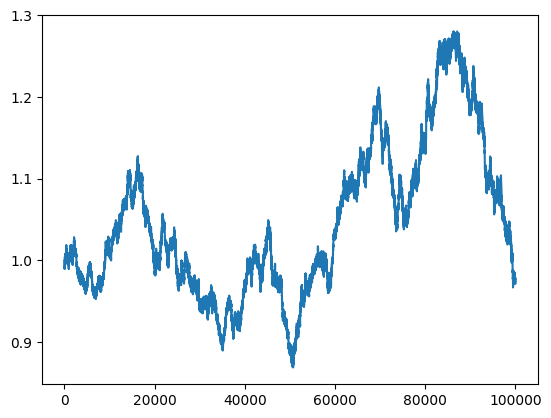

In [6]:
plt.plot(s)

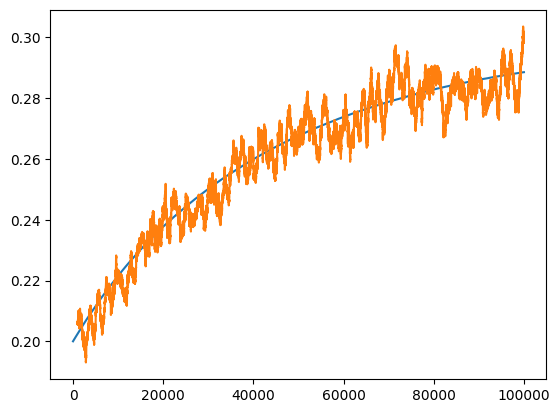

In [5]:
plt.plot(np.sqrt(v))
plt.plot(v_tilde)